### Fine-tune BERT Base model for Support Ticket Dataset Classification

In [11]:
from datasets import load_dataset
from datasets import DatasetDict, Dataset

import matplotlib.pyplot as plt

from transformers import (logging,
    AutoTokenizer, DataCollatorWithPadding, 
    AutoModelForSequenceClassification, TrainingArguments, Trainer
    )
import evaluate
import numpy as np
import pandas as pd

# ignore warnings from transformers lib
logging.set_verbosity_error() 

### 1. Load data from Support Tickets Dataset

<b>1.1 Load Support Tickets Dataset fom HuggingFace Hub</b>

In [2]:
support_tickets = load_dataset("phi-ai-info/support_tickets")

In [3]:
support_tickets

DatasetDict({
    train: Dataset({
        features: ['subject', 'description', 'key_phrase'],
        num_rows: 60
    })
})

<b>2.1 Convert support_tickets Dataset into Pandas DataFrame</b>

In [4]:
def dataset_to_df(dataset_obj, 
                  label=None):
    cols = list(dataset_obj[0].keys())
    labels = []

    cols_values = {item:[] for item in cols}
    for json_rec in dataset_obj:
        for item in cols:
            cols_values[item].append(json_rec[item])
    
    if label is not None:
        new_key = 'label'
        cols += [new_key]
        cols_values[new_key] = []
        for json_rec in dataset_obj:
            cols_values[new_key].append(label[json_rec['key_phrase']])
    
    return pd.DataFrame({item:cols_values[item] for item in cols})

In [5]:
label_dict = {'grant access': 0,
 'revoke access': 0,
 'access profile': 0,
 'disk space': 1,
 'disk full': 1,
 'disk error': 1,
 'add user': 2,
 'delete user': 2,
 'create user': 2,
 'modify user': 2}

df_set = dataset_to_df(support_tickets['train'], 
                       label=label_dict)

df_set

In [6]:
random_index = np.random.permutation(df_set.index)
random_index

array([59, 10, 54, 17, 48, 47, 29, 39, 44, 30, 41, 13, 33,  3, 25, 34,  8,
       20, 12, 14, 24, 42, 27,  1,  5, 37,  6,  7, 16, 43, 40, 11, 21,  2,
       49,  9, 26, 56, 15, 45, 36, 46, 23, 52, 31, 38, 19,  4, 51, 28, 57,
       55, 32, 22, 50, 58, 18, 35,  0, 53], dtype=int64)

In [7]:
subsets = ['train','valid','test']
split_ind = np.array([[0,40],[40,50],[50,60]])
ind2subset = {key:random_index[split_ind[i][0]:split_ind[i][1]] for i,key in enumerate(subsets)}
ind2subset

{'train': array([59, 10, 54, 17, 48, 47, 29, 39, 44, 30, 41, 13, 33,  3, 25, 34,  8,
        20, 12, 14, 24, 42, 27,  1,  5, 37,  6,  7, 16, 43, 40, 11, 21,  2,
        49,  9, 26, 56, 15, 45], dtype=int64),
 'valid': array([36, 46, 23, 52, 31, 38, 19,  4, 51, 28], dtype=int64),
 'test': array([57, 55, 32, 22, 50, 58, 18, 35,  0, 53], dtype=int64)}

In [8]:
df_set.iloc[ind2subset['train']]

,subject,description,key_phrase,label
59,Modify User Account,Modify my user account by providing more rights,modify user,2
10,Access Removal for Inactive Users,Revoke access for inactive users.,revoke access,0
54,Modify User Permission,Modify permissions for users for the marketing...,modify user,2
17,Update Access Levels,Update access levels for profile for IT depart...,access profile,0
48,Create Temporary User,Create temporary user account for contractor.,create user,2
47,Add User Role,add a new user for Don's.,add user,2
29,Insufficient Disk Space,Lack of disk space hindering system performance.,disk space,1
39,Disk Space Reallocation,Need to reallocate disk space for new priorities.,disk space,1
44,Create new User Account,create a user profile using known information.,create user,2
30,Disk Space Capacity Upgrade,Request to increase disk space size.,disk space,1


<b>1.3 Create a Dataset with Train, Validation and Test splits</b>

In [12]:
ds_splits = DatasetDict({
                        'train': Dataset.from_pandas(
                                                    df_set.iloc[ind2subset['train']]
                                                    ),
                        'valid': Dataset.from_pandas(
                                                    df_set.iloc[ind2subset['valid']]
                                                    ),
                        'test': Dataset.from_pandas(
                                                    df_set.iloc[ind2subset['test']]
                                                    )
                        })
ds_splits

DatasetDict({
    train: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 40
    })
    valid: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
    test: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
})

In [13]:
subsets = ['train','valid','test']
split_dict = { key: Dataset.from_pandas(df_set.iloc[ind2subset[key]]) for key in subsets}
support_tickets_splits = DatasetDict(split_dict)
support_tickets_splits

DatasetDict({
    train: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 40
    })
    valid: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
    test: Dataset({
        features: ['subject', 'description', 'key_phrase', 'label', '__index_level_0__'],
        num_rows: 10
    })
})

### 2. Train BERT base Model

<b>2.1 Load model from HuggingFace Hub</b>

In [14]:
model_path = "google-bert/bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "access", 1: "disk", 2: "user"}
label2id = {id2label[key]:key for key in id2label}

model = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=len(list(id2label.keys())), 
                                                           id2label=id2label, 
                                                           label2id=label2id,
                                                          )

<b>2.2 Viz Model Stru</b>

In [15]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


<b>2.3 Freeze base model</b>

In [16]:
# freeze base model parameters and unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [17]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

#### 3. Training Helpers

<b>3.1 Preprocess Text Data</b>

In [26]:
# define text preprocessing
def preprocess_function(examples):
    return tokenizer(examples["description"], truncation=True)

In [27]:
# tokenize all datasetse
tokenized_data = support_tickets_splits.map(preprocess_function, batched=True)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [28]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

<b>3.2 Evaluation metrics</b>

In [29]:
# load metrics
accuracy = evaluate.load("accuracy")
#auc_score = evaluate.load("roc_auc")

def compute_softmax(preds):
    max_val = preds.max()
    pred_exp = np.exp(preds-max_val)
    probs = pred_exp/pred_exp.sum(-1, keepdims=True)
    return probs 


def compute_metrics(eval_pred):
    # get predictions
    predictions, labels = eval_pred
    
    # apply softmax to get probabilities
    probabilities = compute_softmax(predictions)
    # use probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]
    # compute auc
    #auc = float(round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'],3))
    
    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
    # compute accuracy
    acc = float(round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'],3))
    
    return {"Accuracy": acc}#, "AUC": auc}

#### 4. Train model

<b>4.1 Set Training Arguments</b>

In [30]:
# hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 10

training_args = TrainingArguments(
    output_dir="bert_ticket_classifier",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

<b>4.2 Define Trainer Module</b>

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

C:\Users\18623\AppData\Local\Temp\ipykernel_32212\3503528392.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<b>4.3 Fine-tune BERT Model</b>

In [32]:
trainer.train()

C:\Users\18623\anaconda3\envs\transformers\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 1.0973, 'grad_norm': 3.6304123401641846, 'learning_rate': 0.00018, 'epoch': 1.0}
{'eval_loss': 1.0796819925308228, 'eval_Accuracy': 0.3, 'eval_runtime': 0.0245, 'eval_samples_per_second': 408.618, 'eval_steps_per_second': 81.724, 'epoch': 1.0}
{'loss': 1.0282, 'grad_norm': 9.829153060913086, 'learning_rate': 0.00016, 'epoch': 2.0}
{'eval_loss': 1.163307785987854, 'eval_Accuracy': 0.2, 'eval_runtime': 1.036, 'eval_samples_per_second': 9.652, 'eval_steps_per_second': 1.93, 'epoch': 2.0}
{'loss': 0.9322, 'grad_norm': 4.931828022003174, 'learning_rate': 0.00014, 'epoch': 3.0}
{'eval_loss': 1.0480681657791138, 'eval_Accuracy': 0.2, 'eval_runtime': 1.0413, 'eval_samples_per_second': 9.604, 'eval_steps_per_second': 1.921, 'epoch': 3.0}
{'loss': 0.9162, 'grad_norm': 7.593883991241455, 'learning_rate': 0.00012, 'epoch': 4.0}
{'eval_loss': 0.95982825756073, 'eval_Accuracy': 0.4, 'eval_runtime': 0.0665, 'eval_samples_per_second': 150.294, 'eval_steps_per_second': 30.059, 'epoch': 4.0}
{'

TrainOutput(global_step=50, training_loss=0.8343485164642334, metrics={'train_runtime': 24.5539, 'train_samples_per_second': 16.291, 'train_steps_per_second': 2.036, 'train_loss': 0.8343485164642334, 'epoch': 10.0})

<b>4.4 Extract Training History</b>

In [33]:
trainer.state.log_history[18]

{'loss': 0.7039,
 'grad_norm': 3.613740921020508,
 'learning_rate': 0.0,
 'epoch': 10.0,
 'step': 50}

In [34]:
trainer.state.log_history[19]

{'eval_loss': 0.7939711809158325,
 'eval_Accuracy': 0.7,
 'eval_runtime': 0.032,
 'eval_samples_per_second': 312.567,
 'eval_steps_per_second': 62.513,
 'epoch': 10.0,
 'step': 50}

In [35]:
trainer.state.log_history[20]

{'train_runtime': 24.5539,
 'train_samples_per_second': 16.291,
 'train_steps_per_second': 2.036,
 'total_flos': 3173805601344.0,
 'train_loss': 0.8343485164642334,
 'epoch': 10.0,
 'step': 50}

In [36]:
len(trainer.state.log_history[:-1]),len(trainer.state.log_history)

(20, 21)

In [37]:
learning_history = trainer.state.log_history[:-1]

In [38]:
hist_dict = {
'train_loss': [],
'valid_loss': [],
'valid_acc': []
}

for item in learning_history:
    if 'loss' in item:
        hist_dict['train_loss'].append(item['loss'])
        continue
        
    if 'eval_loss' in item:
        hist_dict['valid_loss'].append(item['eval_loss'])
        hist_dict['valid_acc'].append(item['eval_Accuracy'])

In [39]:
for key in  hist_dict:
    print(key,hist_dict[key])

train_loss [1.0973, 1.0282, 0.9322, 0.9162, 0.8149, 0.7575, 0.7442, 0.6678, 0.6813, 0.7039]
valid_loss [1.0796819925308228, 1.163307785987854, 1.0480681657791138, 0.95982825756073, 0.8852310180664062, 0.8261047601699829, 0.7992247343063354, 0.7874425649642944, 0.7939541935920715, 0.7939711809158325]
valid_acc [0.3, 0.2, 0.2, 0.4, 0.5, 0.7, 0.8, 0.7, 0.7, 0.7]


Text(0.5, 0, 'Epochs')

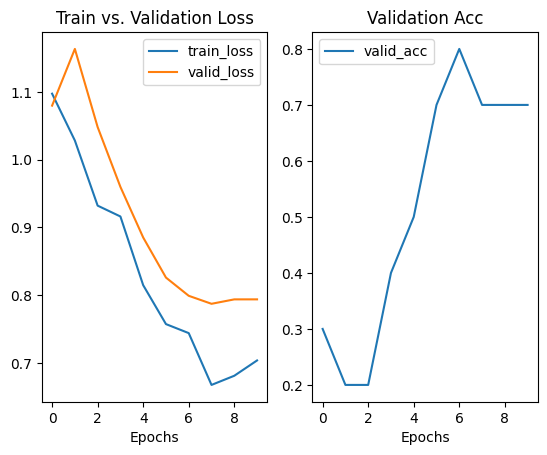

In [40]:
plt.subplot(1,2,1)
for key in  list(hist_dict.keys())[:-1]:
    plt.plot(hist_dict[key])
plt.legend(list(hist_dict.keys())[:-1])
plt.title('Train vs. Validation Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
for key in  [list(hist_dict.keys())[-1]]:
    plt.plot(hist_dict[key])
plt.legend([list(hist_dict.keys())[-1]])
plt.title('Validation Acc')
plt.xlabel('Epochs')

<b> 4.5 Apply Model to Validation Dataset</b>

In [46]:
# apply model to validation dataset
predictions = trainer.predict(tokenized_data["valid"])

# Extract the logits and labels from the predictions object
logits = predictions.predictions
labels = predictions.label_ids

# Use your compute_metrics function
#metrics = compute_metrics((logits, labels))
#print(metrics)
true_count = 0
for pred_l,actu_l in zip(labels,support_tickets_splits['test']['label']): 
    if pred_l == actu_l:
        true_count += 1
print(f'Accuracy {true_count/len(labels)}')

Accuracy 0.3


In [47]:
labels

array([1, 2, 1, 2, 1, 1, 0, 0, 2, 1], dtype=int64)

In [48]:
support_tickets_splits['test']['label']

[2, 2, 1, 1, 2, 2, 0, 1, 0, 2]

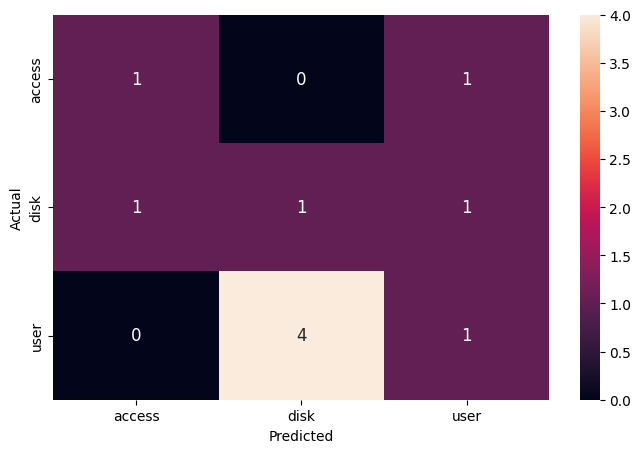

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

font_size = 12
label_class = ['access','disk','user']
cl_rep = classification_report(support_tickets_splits['test']['label'],
                               labels,
                               target_names=label_class,
                               output_dict=True
                            )

cm = confusion_matrix(support_tickets_splits['test']['label'],
                      labels)

plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            xticklabels=label_class,
            yticklabels=label_class,
            annot = True,  fmt = '.0f',
            annot_kws={'size': font_size})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [50]:
df = pd.DataFrame(cl_rep)
df

,access,disk,user,accuracy,macro avg,weighted avg
precision,0.5,0.200000,0.333333,0.3,0.344444,0.326667
recall,0.5,0.333333,0.200000,0.3,0.344444,0.300000
f1-score,0.5,0.250000,0.250000,0.3,0.333333,0.300000
support,2.0,3.000000,5.000000,0.3,10.000000,10.000000


In [51]:
# # push model to hub
# trainer.push_to_hub()